In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import pandas as pd
import time
import pickle
from pathlib import Path
import re
from model_1p7 import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='notebook', style='whitegrid', rc={"font.family": "DejaVu Serif"})

In [2]:
df, dff, sim, net = simulate(1, 'V', 0, 13, 80, 'random')

trial 1
trial 10
trial 20
trial 30
trial 40
trial 50
trial 60
trial 70
trial 80


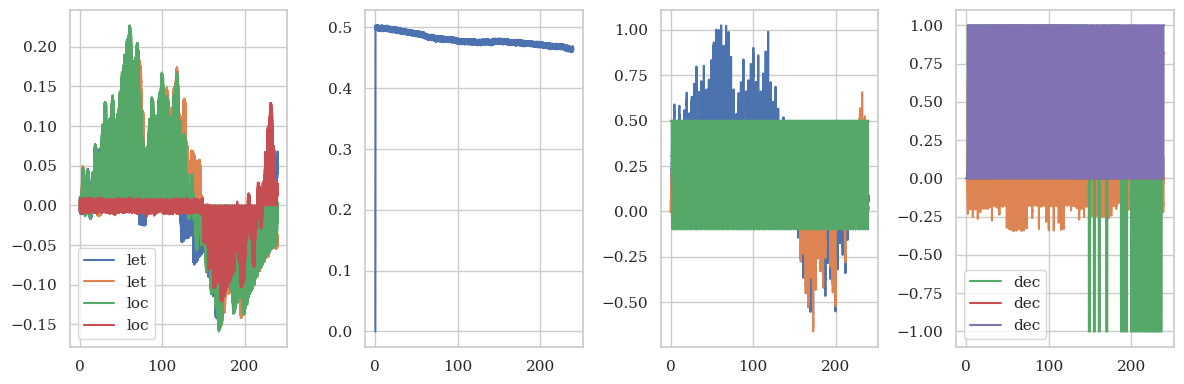

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, figsize=(12,4))
axes[0].plot(sim.trange(), sim.data[net.p_v][:,:2], label='let')
axes[0].plot(sim.trange(), sim.data[net.p_v][:,2:], label='loc')
axes[1].plot(sim.trange(), sim.data[net.p_w])
axes[2].plot(sim.trange(), sim.data[net.p_a])
axes[3].plot(sim.trange(), sim.data[net.p_ch])
axes[3].plot(sim.trange(), sim.data[net.p_dec], label='dec')
axes[2].plot(sim.trange(), sim.data[net.p_thr])
# axes[3].plot(sim.trange(), sim.data[net.p_rew][:,3], label='acc')
# axes[3].plot(sim.trange(), sim.data[net.p_ew])
# axes[3].plot(sim.trange(), sim.data[net.p_mask_learn])
# axes[0].set(xlim=[110,120])
axes[0].legend()
axes[3].legend()
plt.tight_layout()
plt.show()

In [2]:
def plot_values(nef_data, x='rev', window_size=5):
    target_blocks = ['loc_RL', 'loc_LR', 'let_AB', 'let_BA']
    pretty_labels = {
        'let_AB': 'What\nA \u2192 B',
        'let_BA': 'What\nB \u2192 A',
        'loc_LR': 'Where\nL \u2192 R',
        'loc_RL': 'Where\nR \u2192 L'
    }
    
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(18, 14), sharex=True, sharey="col")
    titles = ['Values', 'Weights', 'Actions', 'Outcomes', 'RTs']
    columns_to_plot = [['va', 'vb', 'vl', 'vr'], ['w'], ['al', 'ar'], ['acc'], ['tdec']]
    all_metrics = [m for sublist in columns_to_plot for m in sublist]

    for row_idx, b_type in enumerate(target_blocks):
        df = nef_data[nef_data['block_type'] == b_type].copy()
        if df.empty: continue
        df['after_rev'] = df['rev'] >= 0
        for col in all_metrics:
            df[col] = df.groupby(['monkey', 'session', 'block', 'after_rev'])[col].transform(lambda x: x.rolling(window=window_size, center=True, min_periods=1).mean())
        for col_idx, cols in enumerate(columns_to_plot):
            ax = axes[row_idx, col_idx]
            for metric in cols:
                sns.lineplot(data=df, x=x, y=metric, ax=ax, label=metric)
            ax.axvline(0, color='black', linestyle='--', alpha=0.3)
            ax.set(xlim=[-45, 45], ylabel=None) 
            if ax.get_legend(): ax.get_legend().remove()
            if row_idx == 0:
                ax.set_title(titles[col_idx], fontweight='bold', pad=20)
            if col_idx == 0:
                ax.set_ylabel(pretty_labels.get(b_type, b_type), fontweight='bold', rotation=0, labelpad=50, verticalalignment='center')

    fig.suptitle(f"Model Performance (Window Size: {window_size})", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [3]:
def plot_performance(nef_data, window_size=5):
    emp = pd.read_pickle("data/empirical.pkl")
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    type_map = {'let_AB': 'what', 'let_BA': 'what', 'loc_LR': 'where', 'loc_RL': 'where'}
    for dataset in [emp, nef_data]:
        dataset['super_type'] = dataset['block_type'].map(type_map).fillna(dataset['block_type'])
        target_col = 'monkey_accuracy' if 'monkey_accuracy' in dataset.columns else 'acc'
        dataset['after_rev'] = dataset['rev'] >= 0
        dataset['smoothed_acc'] = dataset.groupby(['monkey', 'super_type', 'session', 'block', 'after_rev'])[target_col].transform(lambda x: x.rolling(window=window_size, center=True, min_periods=1).mean())

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharex=True, sharey=True)
    
    sns.lineplot(data=emp, x='rev', y='smoothed_acc', hue='super_type', hue_order=['what', 'where'], ax=axes[0])
    axes[0].set_title('Empirical Data')
    axes[0].set(xlim=[-45, 45], xlabel='Trial Relative to Reversal', ylabel='Accuracy', ylim=[0, 1])
    axes[0].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[0].legend(title='Block Type')

    sns.lineplot(data=nef_data, x='rev', y='smoothed_acc', hue='super_type', hue_order=['what', 'where'], ax=axes[1])
    axes[1].set_title('NEF Model')
    axes[1].set(xlabel='Trial Relative to Reversal', ylim=[0, 1])
    axes[1].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[1].legend(title='Block Type')

    plt.tight_layout()
    plt.show()

In [4]:
def adjust_df(df):
    df['acc'] = df['acc'].replace(-1, 0)
    emp = pd.read_pickle("data/empirical2.pkl")
    block_mapping = emp[['block', 'block_type']].drop_duplicates().set_index('block')['block_type']
    df['block_type'] = df['block'].map(block_mapping)
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    join_keys = ['monkey', 'session', 'block', 'trial']
    extra_cols = ['rev', 'cor_let', 'cor_loc']
    df = df.merge(emp[join_keys + extra_cols], on=join_keys, how='left')
    return df

# Population

In [5]:
nef_data = pd.read_pickle("data/nef/nef_data.pkl.xz")
nef_data = adjust_df(nef_data)

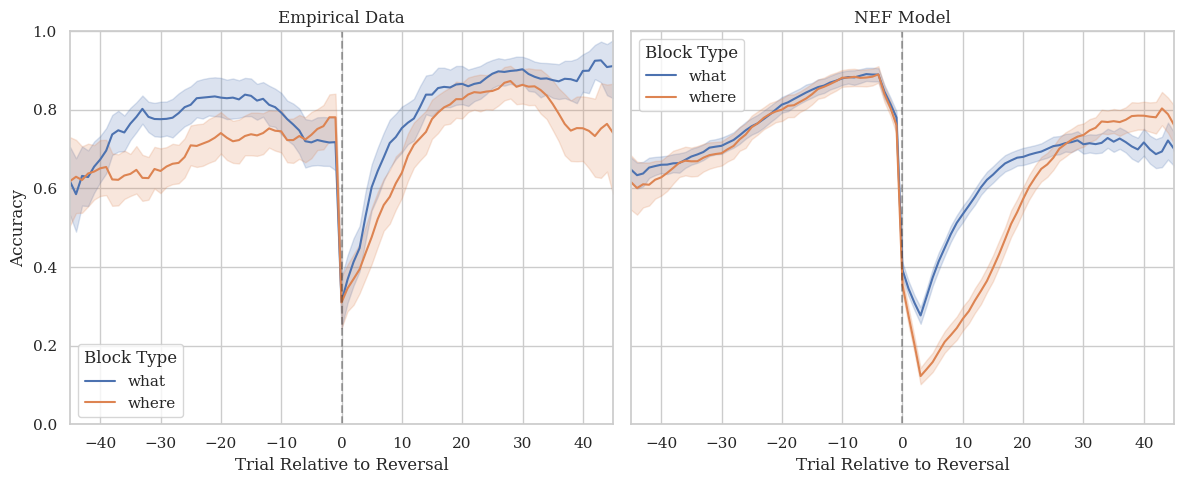

In [6]:
plot_performance(nef_data, window_size=7)

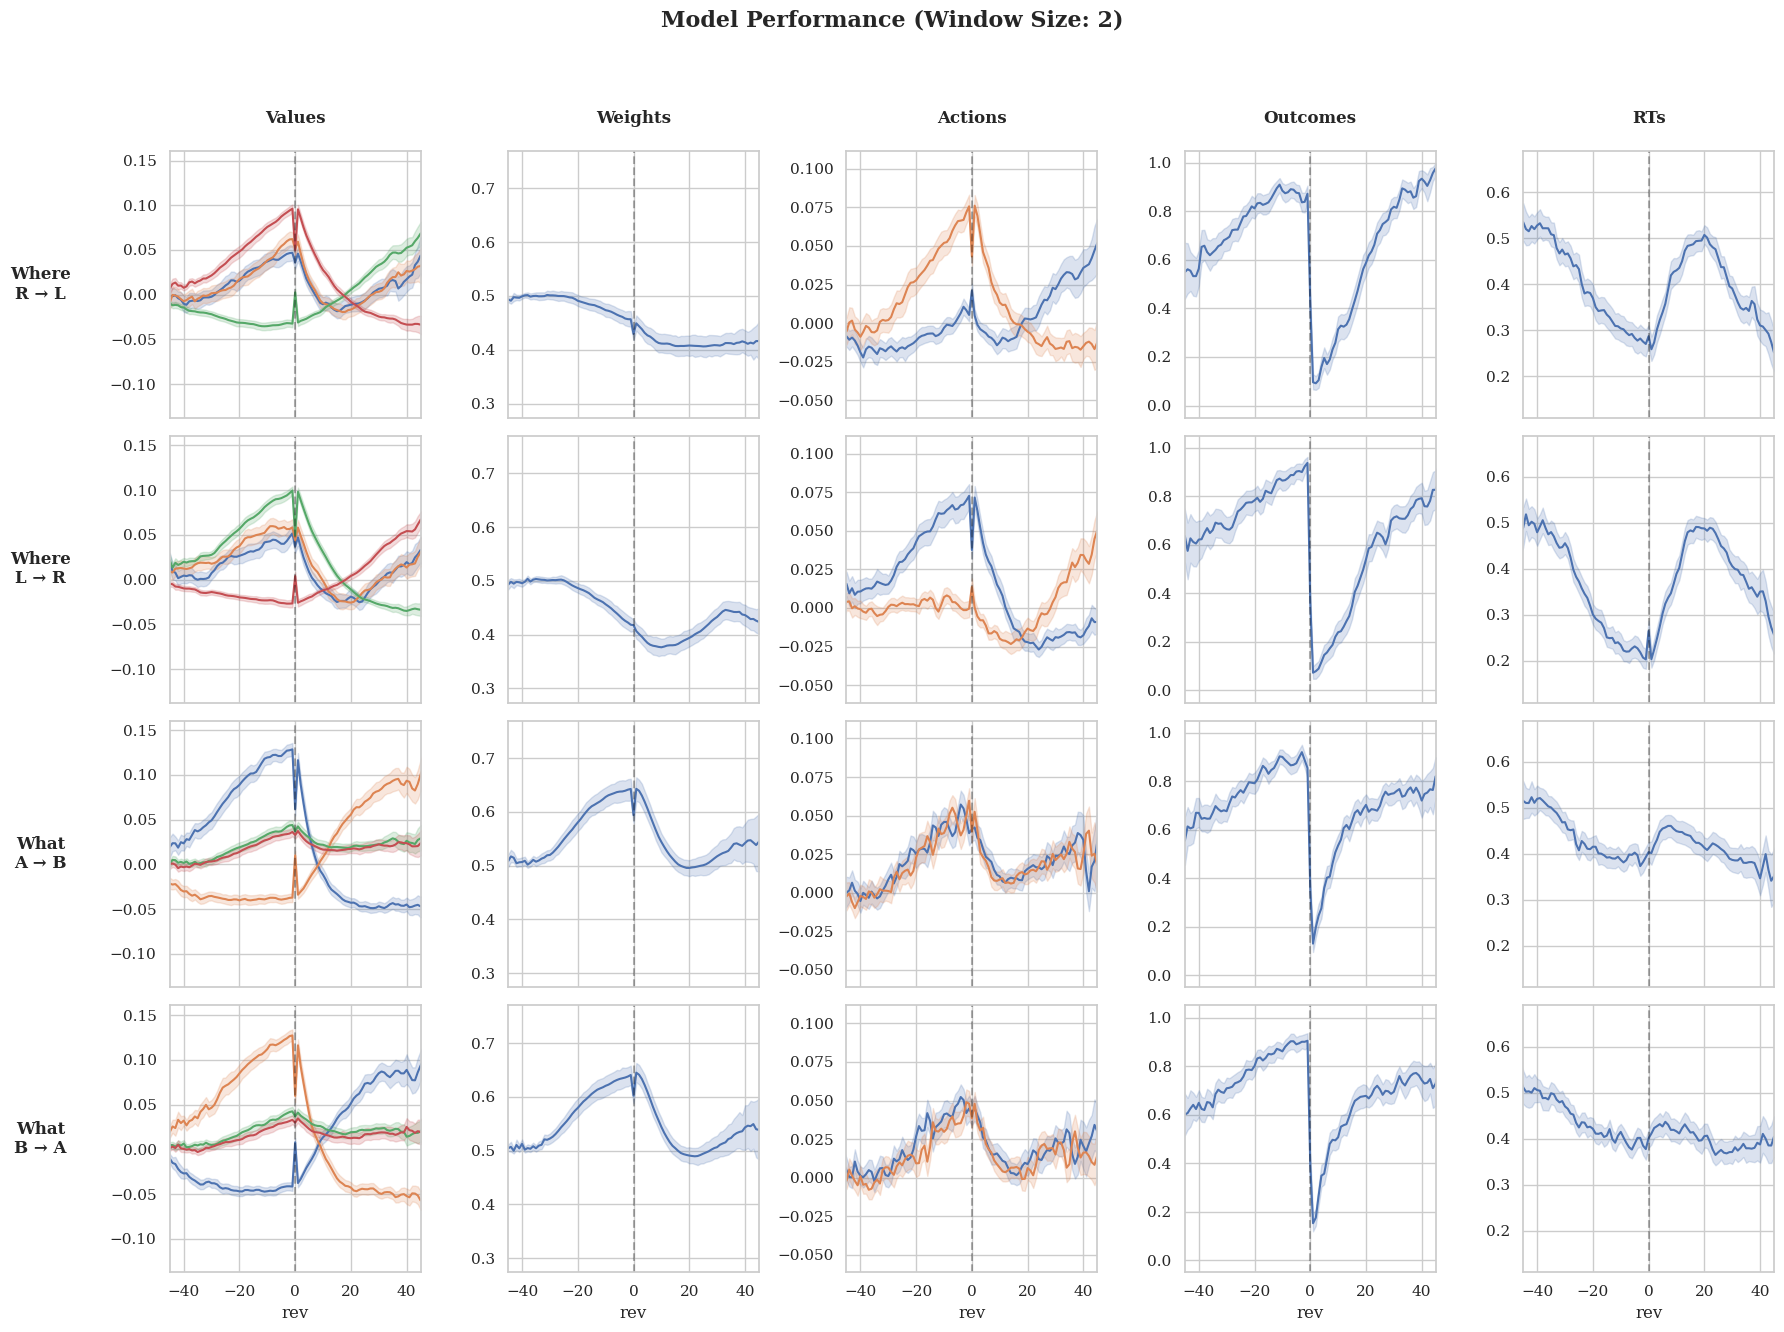

In [7]:
plot_values(nef_data, window_size=2)

# Ramping

In [12]:
def load_adjust_full():
    df = pd.read_pickle("data/nef/nef_data_full.pkl.xz")
    df['acc'] = df['acc'].replace(-1, 0)
    df['trial'] = (np.floor(df['time'] / 3.0) + 1).astype(int)
    emp = pd.read_pickle("data/empirical2.pkl")
    emp_subset = emp[['monkey', 'session', 'block', 'trial', 'cor_loc', 'cor_let', 'block_type', 'reversal_at_trial']].drop_duplicates()
    join_keys = ['monkey', 'session', 'block', 'trial']
    df = df.merge(emp_subset, on=join_keys, how='left')
    df['rev'] = df['trial'] - df['reversal_at_trial']
    is_left = (df['cor_loc'] == 'left')
    df['acor'] = np.where(is_left, df['al'], df['ar'])
    df['ainc'] = np.where(is_left, df['ar'], df['al'])
    df['t_since_cue'] = df['time'] % 3.0 - 1.0
    df['da'] = df['acor'] - df['ainc']
    for col in ['monkey', 'block_type', 'cor_loc', 'cor_let']:
        df[col] = df[col].astype('category')
    return df

In [13]:
nef_data_full = load_adjust_full()

In [19]:
def plot_ramp(df, trial_start=30, trial_end=40):
    df = df.query("@trial_start < rev < @trial_end").copy()
    type_map = {'let_AB': 'What Blocks', 'let_BA': 'What Blocks', 'loc_LR': 'Where Blocks', 'loc_RL': 'Where Blocks'}
    df['super_type'] = df['block_type'].map(type_map)
    categories = ['What Blocks', 'Where Blocks']
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True, sharex=True)
    for i, cat in enumerate(categories):
        data_subset = df[df['super_type'] == cat]
        sns.lineplot(data=data_subset, x='t_since_cue', y='da', ax=axes[i], color=palette[0], alpha=1, label='delta a')
        sns.lineplot(data=data_subset, x='t_since_cue', y='acor', ax=axes[i], color=palette[1], alpha=0.3, label='a correct')
        sns.lineplot(data=data_subset, x='t_since_cue', y='ainc', ax=axes[i], color=palette[2], alpha=0.3, label='a incorrect')
        # sns.lineplot(data=data_subset, x='t_since_cue', y='thr', ax=axes[i], color=palette[3], alpha=0.3, label='a thr')
        axes[i].set_title(cat, fontweight='bold', fontsize=14)
        axes[i].set(xlabel='Time from Cue (s)', ylabel="Action Value" if i == 0 else None)
        axes[i].axvline(0, color='black', linestyle='--', alpha=0.3)
        axes[i].set_xticks(np.linspace(-1,1,11))
        axes[i].set_xlim([-1, 1])
    axes[0].legend()
    plt.tight_layout()
    plt.show()

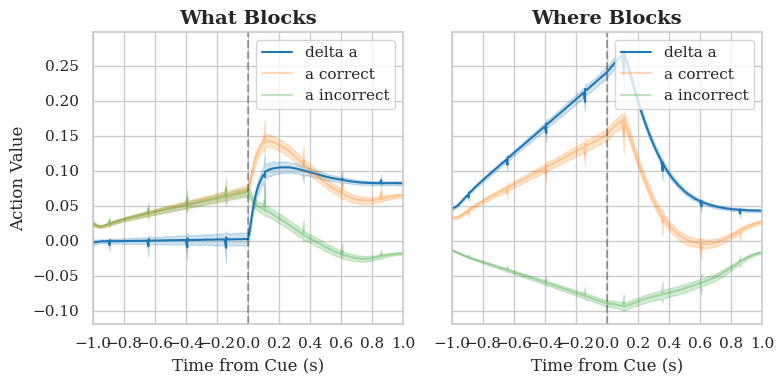

In [20]:
plot_ramp(nef_data_full)

(array([1812.,  745.,  666.,  553.,  613.,  499.,  431.,  389.,  374.,
         328.]),
 array([0.101, 0.178, 0.255, 0.332, 0.409, 0.486, 0.563, 0.64 , 0.717,
        0.794, 0.871]),
 <BarContainer object of 10 artists>)

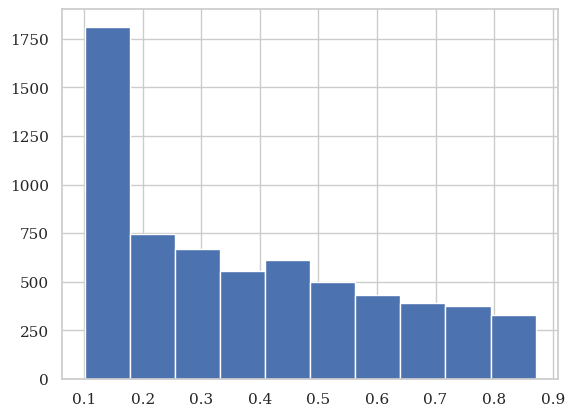

In [23]:
plt.hist(nef_data.query("30 < rev < 40")['tdec'])

In [ ]:
## inhibit v after decision but before reward
## think about reaction times late in the block (median?)
## more LR fiddling to improve w and performance after reversal (gamma_w?)